In [ ]:
!pip install scikit-learn==1.0.2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json
from glob import glob
from imblearn.over_sampling import SMOTE
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


# Libraries for Sentiment Analysis
import nltk
from nltk.corpus import stopwords
import re, string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import LSTM,GRU, Dense, Dropout, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import sklearn
print(sklearn.__version__)

1.0.2


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)
%cd /content/gdrive/MyDrive/RTML_Project_Data

Mounted at /content/gdrive/
/content/gdrive/MyDrive/RTML_Project_Data


In [ ]:
data_file = open("yelp_academic_dataset_business.json")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
data=[]
for chunk in pd.read_json("yelp_academic_dataset_review.json", lines=True, chunksize=5000):
    data.append(chunk)

# Concatenate the chunks into a single DataFrame
reviews_df = pd.concat(data, ignore_index=True)

In [ ]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
print('Size of Business DataFrame: ',business_df.shape)
print('Size of Reviews DataFrame: ',reviews_df.shape)

Size of Business DataFrame:  (150346, 14)
Size of Reviews DataFrame:  (6990280, 9)


In [ ]:
print('Number of Unique Businesses in Review Data: ',reviews_df['business_id'].nunique())
print('Number of Unique Businesses in Business Data: ',business_df['business_id'].nunique())

Number of Unique Businesses in Review Data:  150346
Number of Unique Businesses in Business Data:  150346


#### Business Categories

In [ ]:
business_cats=', '.join(business_df['categories'].dropna())
cats=pd.DataFrame(business_cats.split(', '),columns=['category'])
cats_ser = cats.category.value_counts()
cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

In [ ]:
business_df.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None


In [ ]:
cats_df

,index,category
0,Restaurants,52268
1,Food,27781
2,Shopping,24395
3,Home Services,14356
4,Beauty & Spas,14292
...,...,...
1306,Beach Bars,1
1307,DUI Schools,1
1308,Patent Law,1
1309,Housing Cooperatives,1


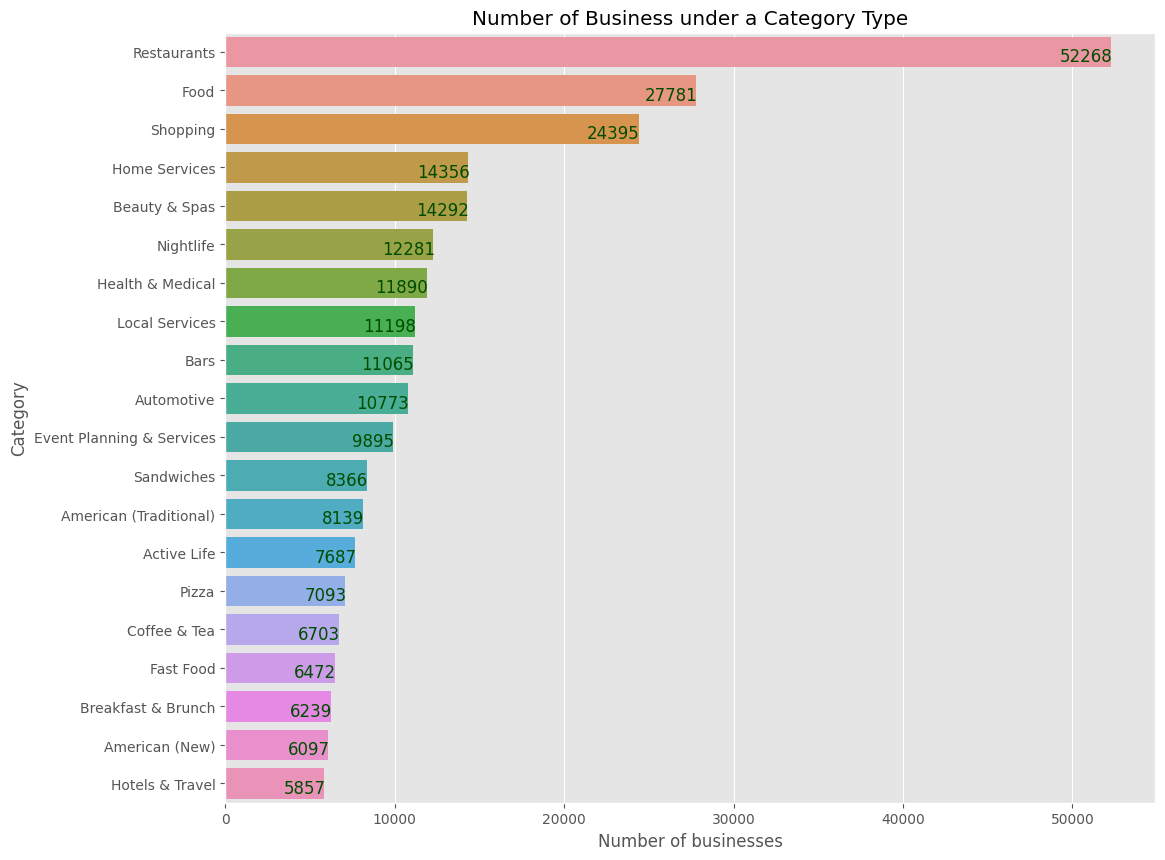

In [ ]:
plt.figure(figsize=(12,10))
ax = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
ax.set_ylabel('Category')
ax.set_xlabel('Number of businesses')
ax.set_title('Number of Business under a Category Type')



for p in ax.patches:
    ax.annotate(int(p.get_width()),
                ((p.get_x() + p.get_width()),
                 p.get_y()),
                 xytext=(1, -18),
                fontsize=12,
                color='#004d00',
                textcoords='offset points',
                horizontalalignment='right')
plt.show()

#### Stars for each Business

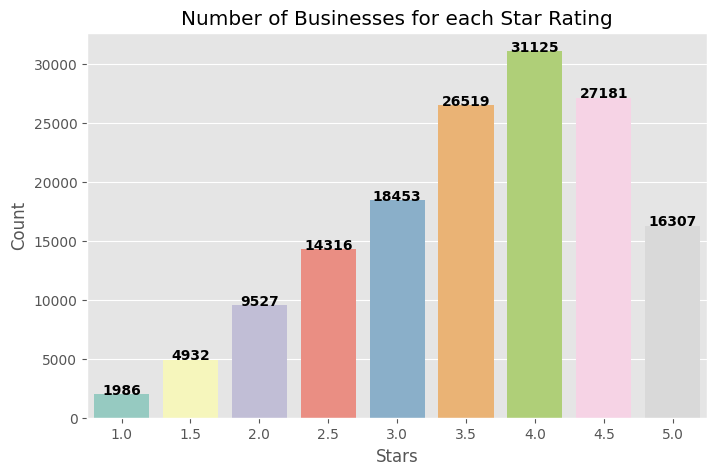

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot( x='stars' , data = business_df, palette='Set3')
ax.set_ylabel('Count')
ax.set_xlabel('Stars')
ax.set_title('Number of Businesses for each Star Rating')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x+width-.4,
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center')

plt.show()

#### Business Status

In [ ]:
business_df['is_open'].value_counts()

1    119698
0     30648
Name: is_open, dtype: int64

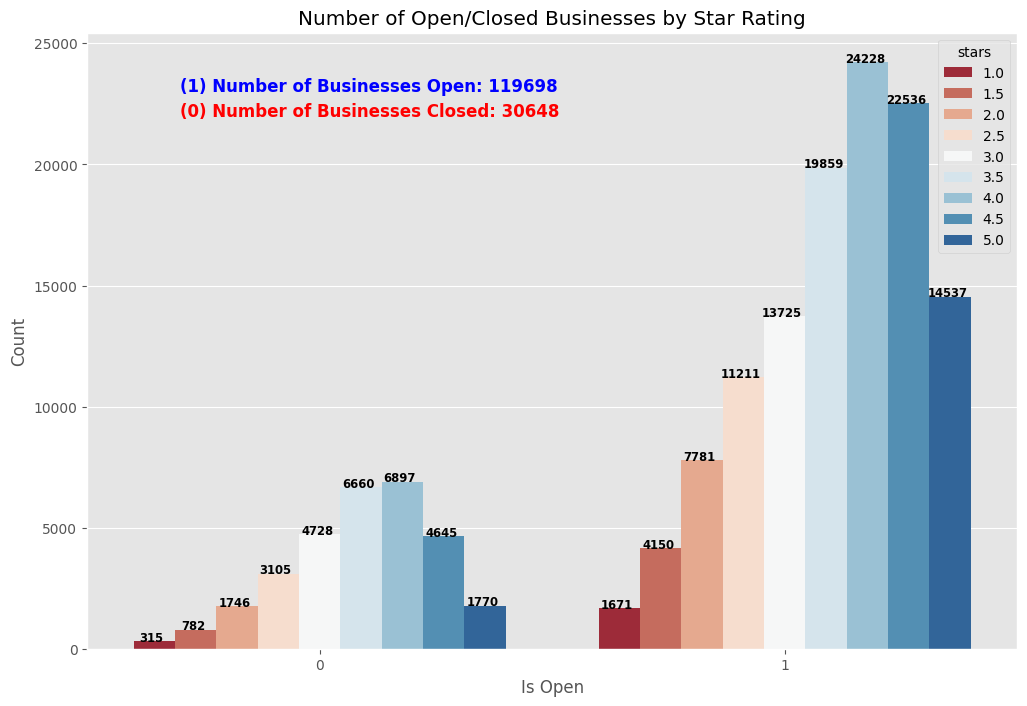

In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(hue='stars', x='is_open'  , data = business_df, palette='RdBu')
ax.set_ylabel('Count')
ax.set_xlabel('Is Open')
ax.set_title('Number of Open/Closed Businesses by Star Rating')


num_open , num_closed = business_df['is_open'].value_counts()

ax.text(-0.3, 23000,
        '(1) Number of Businesses Open: {:.0f}'.format(num_open),
        weight='bold',
        color='blue',
        size='large')

ax.text(-0.3, 22000,
        '(0) Number of Businesses Closed: {:.0f}'.format(num_closed),
        weight='bold',
        color='red',
        size='large')



for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x+width-.05,
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small')

plt.show()

#### Businesses Per State

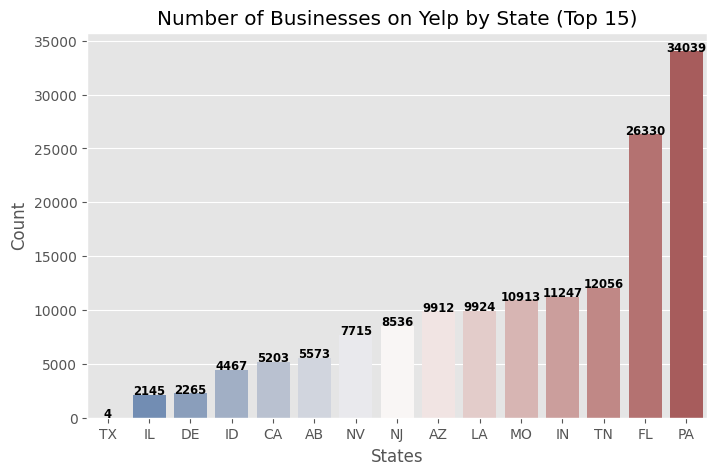

In [ ]:
top15 = business_df['state'].value_counts(ascending=True).tail(15).to_frame()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=top15.index,y='state', data=top15, palette='vlag')
ax.set_ylabel('Count')
ax.set_xlabel('States')
ax.set_title('Number of Businesses on Yelp by State (Top 15)')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.text(x+width-.4,
                y+height+2,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
               size='small')

plt.show()

### Build Sentimental Analysis Model

In [ ]:
# Recode 1,2 stars as 0 (negative review)
# Recode 3,4 and 5 stars as 1 (positive review)

reviews_df['sentiment']=reviews_df['stars'].replace({1:0,2:0,3:1,4:1,5:1})
reviews_df['sentiment'] = reviews_df['sentiment'].astype(int)

In [ ]:
# Since this dataset is so large, we will work with a random sample of 100,000 reviews

reviews_subset = reviews_df.sample(100000).reset_index(drop=True)

In [ ]:
# Subset of the columns of interest

df = reviews_subset[['text','sentiment']]
df.head()

,text,sentiment
0,Very poor customer service. Been to this loca...,0
1,Support Local!\nAfter getting upset at a certa...,1
2,"First of all, there was no water at all. They ...",0
3,I cancelled my membership to BJ's years ago. I...,0
4,Expansive collection. Aisles marked for one wa...,1


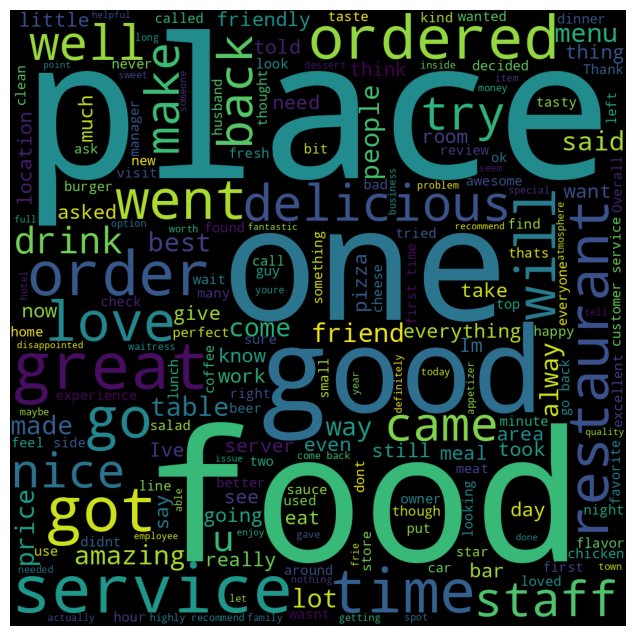

In [ ]:
feedbacks = str(' '.join(df['text']).split())
feedbacks = feedbacks.translate(str.maketrans('','',string.punctuation))
feedbacks_wordcloud = WordCloud(background_color='black',max_words=200,width=1000,height=1000,).generate(feedbacks)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(feedbacks_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# Convert strings to lowercase

df['cleaned_text'] = df['text'].apply(lambda x:' '.join(x.lower() for x in str(x).split()))


# Convert contractions into separate words (won't = will not)

def contractions(s):
     s = re.sub(r"won’t", "will not",s)
     s = re.sub(r"would’t", "would not",s)
     s = re.sub(r"could’t", "could not",s)
     s = re.sub(r"\’d",  " would",s)
     s = re.sub(r"can\’t", "can not",s)
     s = re.sub(r"n\’t", " not", s)
     s= re.sub(r"\’re", " are", s)
     s = re.sub(r"\’s", " is", s)
     s = re.sub(r"\’ll", " will", s)
     s = re.sub(r"\’t", " not", s)
     s = re.sub(r"\’ve", " have", s)
     s = re.sub(r"\’m", " am", s)
     return s
df['cleaned_text']=df['cleaned_text'].apply(lambda x:contractions(x))


# Remove non-alpha characters

df['cleaned_text']=df['cleaned_text'].apply(lambda x: ' '.join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))


# Remove extra spaces between words

df['cleaned_text']=df['cleaned_text'].apply(lambda x: re.sub(' +', ' ', x))


# Remove stop words

stop = stopwords.words("english")
stop += ['would','may','one', 'must','upon','might','ought','shall','could','got','went','going','made','said']
df['cleaned_text']=df['cleaned_text'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))


# Lemmatization

lemmatizer = WordNetLemmatizer()
df['cleaned_text']=df['cleaned_text'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))



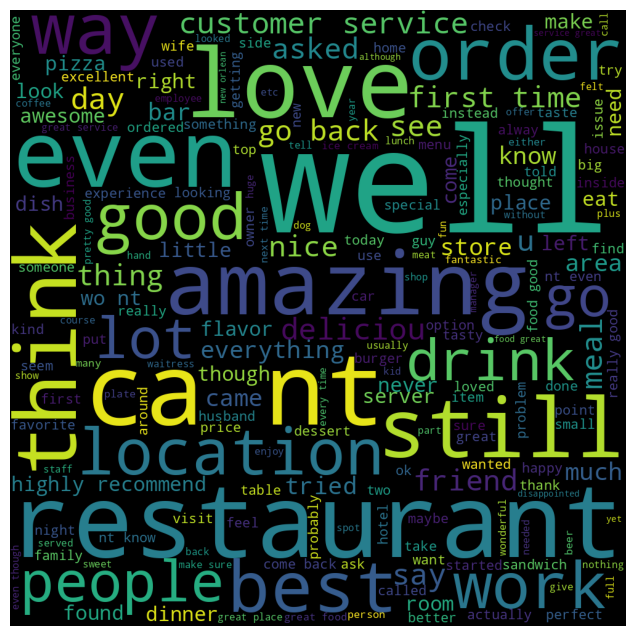

In [ ]:
feedbacks = str(' '.join(df['cleaned_text']).split())
feedbacks = feedbacks.translate(str.maketrans('','',string.punctuation))
feedbacks_wordcloud = WordCloud(background_color='black',max_words=200,width=1000,height=1000,).generate(feedbacks)
plt.figure(figsize=(8,8))
plt.clf()
plt.imshow(feedbacks_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
df.sentiment.value_counts()

1    77038
0    22962
Name: sentiment, dtype: int64

In [ ]:
X = df['cleaned_text']
y = df['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (80000,) (80000,) Test:  ((20000,), (20000,))


In [ ]:
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [ ]:
word_counts = np.array(np.sum(tf_x_train, axis=0)).reshape((-1,))
words = np.array(vectorizer.get_feature_names())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

,word,count
22821,food,2516.517719
25868,great,2370.127376
41618,nt,2323.638981
46077,place,2232.490718
25368,good,2197.660330
54399,service,1820.413016
61973,time,1731.910892
4049,back,1400.734324
24750,get,1393.285231
34537,like,1325.328091


In [ ]:
sm = SMOTE(random_state=1)
X_bal, y_bal = sm.fit_resample(tf_x_train, y_train)


In [ ]:
y_bal.value_counts()

1    61630
0    61630
Name: sentiment, dtype: int64

### Linear SVC Model

In [ ]:
grid_search_clf = LinearSVC()
grid_search_clf.fit(X_bal, y_bal)


y_test_pred_clf=grid_search_clf.predict(tf_x_test)

report_clf=classification_report(y_test, y_test_pred_clf,output_dict=True)
pd.DataFrame(report_clf)

,0,1,accuracy,macro avg,weighted avg
precision,0.787611,0.955017,0.9134,0.871314,0.916581
recall,0.852787,0.931464,0.9134,0.892126,0.913400
f1-score,0.818904,0.943094,0.9134,0.880999,0.914580
support,4592.000000,15408.000000,0.9134,20000.000000,20000.000000


### Random Forests Model

In [ ]:
rf_model = RandomForestClassifier()

param_grid = {'n_estimators': [20,50, 100], 'max_depth': [10, 50, None]}



grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5)

grid_search_rf.fit(X_bal, y_bal)


print("Best Hyperparameters: ", grid_search_rf.best_params_)
print("Best Score: ", grid_search_rf.best_score_)

y_test_pred_rf=grid_search_rf.predict(tf_x_test)

report_rf=classification_report(y_test, y_test_pred_rf,output_dict=True)
pd.DataFrame(report_rf)

Best Hyperparameters:  {'max_depth': None, 'n_estimators': 100}
Best Score:  0.9306019795554112


,0,1,accuracy,macro avg,weighted avg
precision,0.757805,0.917476,0.8827,0.837641,0.880816
recall,0.718859,0.931529,0.8827,0.825194,0.882700
f1-score,0.737819,0.924449,0.8827,0.831134,0.881599
support,4592.000000,15408.000000,0.8827,20000.000000,20000.000000


### Naive Bayes Model

In [ ]:
naiv_bay_model = MultinomialNB()

param_grid = {'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]}

grid_search_nb = GridSearchCV(naiv_bay_model, param_grid, cv=5)

grid_search_nb.fit(X_bal, y_bal)


print("Best Hyperparameters: ", grid_search_nb.best_params_)
print("Best Score: ", grid_search_nb.best_score_)

y_test_pred_nb=grid_search_nb.predict(tf_x_test)

report_nb=classification_report(y_test, y_test_pred_nb,output_dict=True)
pd.DataFrame(report_nb)

Best Hyperparameters:  {'alpha': 0.1}
Best Score:  0.9014765536264806


,0,1,accuracy,macro avg,weighted avg
precision,0.692224,0.945482,0.87595,0.818853,0.887334
recall,0.827744,0.890317,0.87595,0.859030,0.875950
f1-score,0.753942,0.917071,0.87595,0.835506,0.879616
support,4592.000000,15408.000000,0.87595,20000.000000,20000.000000


### LSTM Model

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])

X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=100, padding='post', truncating='post')

y = np.array(df['sentiment'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.0770 - accuracy: 0.9722 - val_loss: 0.2845 - val_accuracy: 0.9110
Epoch 2/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.0608 - accuracy: 0.9784 - val_loss: 0.3347 - val_accuracy: 0.9093
Epoch 3/10
2500/2500 [==============================] - 19s 7ms/step - loss: 0.0497 - accuracy: 0.9831 - val_loss: 0.3553 - val_accuracy: 0.9082
Epoch 4/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.0395 - accuracy: 0.9870 - val_loss: 0.4077 - val_accuracy: 0.9061
Epoch 5/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.0333 - accuracy: 0.9890 - val_loss: 0.4610 - val_accuracy: 0.9056
Epoch 6/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.0274 - accuracy: 0.9917 - val_loss: 0.4321 - val_accuracy: 0.9018
Epoch 7/10
2500/2500 [==============================] - 19s 8ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.4562 - val_ac

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)


625/625 [==============================] - 3s 4ms/step - loss: 0.4812 - accuracy: 0.9015
Test Accuracy: 0.9014999866485596


In [ ]:
y_test_pred_lstm = model.predict(X_test)
y_test_pred_lstm = y_test_pred_lstm.round()

625/625 [==============================] - 2s 3ms/step


In [ ]:
report_lstm=classification_report(y_test, y_test_pred_lstm,output_dict=True)
pd.DataFrame(report_lstm)

,0,1,accuracy,macro avg,weighted avg
precision,0.827983,0.920890,0.9015,0.874436,0.899019
recall,0.734070,0.953047,0.9015,0.843559,0.901500
f1-score,0.778203,0.936693,0.9015,0.857448,0.899384
support,4708.000000,15292.000000,0.9015,20000.000000,20000.000000


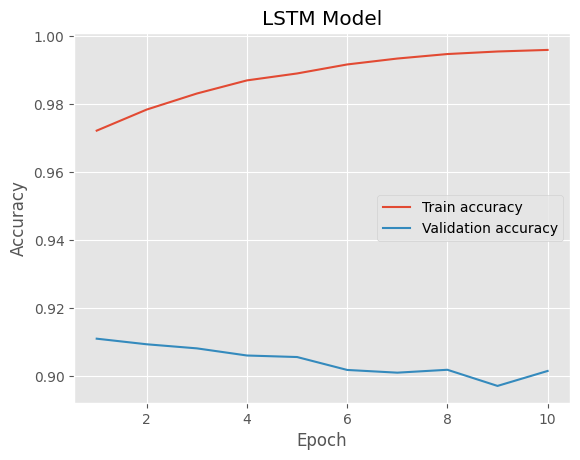

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
test_acc = accuracy

epochs = np.arange(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('LSTM Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()







### GRU Model

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))
model.add(GRU(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2500/2500 [==============================] - 871s 344ms/step - loss: 0.3205 - accuracy: 0.8678 - val_loss: 0.2071 - val_accuracy: 0.9142
Epoch 2/10
2500/2500 [==============================] - 27s 11ms/step - loss: 0.1697 - accuracy: 0.9328 - val_loss: 0.1952 - val_accuracy: 0.9226
Epoch 3/10
2500/2500 [==============================] - 25s 10ms/step - loss: 0.1417 - accuracy: 0.9446 - val_loss: 0.1973 - val_accuracy: 0.9209
Epoch 4/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.1202 - accuracy: 0.9539 - val_loss: 0.2298 - val_accuracy: 0.9159
Epoch 5/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.0967 - accuracy: 0.9633 - val_loss: 0.2414 - val_accuracy: 0.9136
Epoch 6/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.0750 - accuracy: 0.9715 - val_loss: 0.2989 - val_accuracy: 0.9083
Epoch 7/10
2500/2500 [==============================] - 21s 9ms/step - loss: 0.0586 - accuracy: 0.9788 - val_loss: 0.3164 - v

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Test Accuracy:', accuracy)


625/625 [==============================] - 2s 4ms/step - loss: 0.4695 - accuracy: 0.9028
Test Accuracy: 0.9028499722480774


In [ ]:
y_test_pred_gru = model.predict(X_test)
y_test_pred_gru = y_test_pred_gru.round()

625/625 [==============================] - 2s 4ms/step


In [ ]:
report_gru=classification_report(y_test, y_test_pred_gru,output_dict=True)
pd.DataFrame(report_gru)

,0,1,accuracy,macro avg,weighted avg
precision,0.779210,0.942001,0.90285,0.860606,0.904323
recall,0.809678,0.930909,0.90285,0.870293,0.902850
f1-score,0.794152,0.936422,0.90285,0.865287,0.903494
support,4629.000000,15371.000000,0.90285,20000.000000,20000.000000


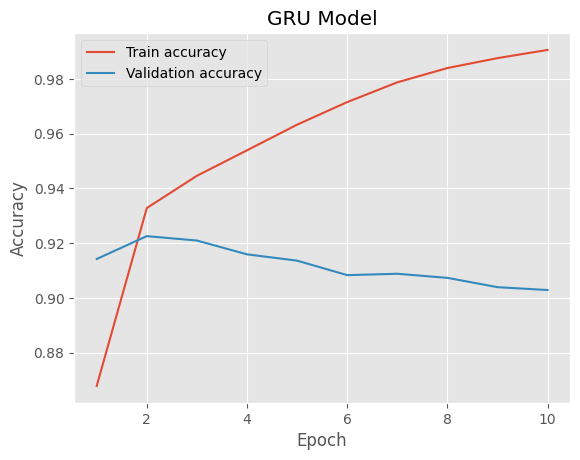

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
test_acc = accuracy

epochs = np.arange(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()







# Testing out the model:

## Sample 1

In [ ]:
df['text'][43]

"IDK what the deal is with the ceiling..... Oh BBC you are hilarious!! I love that you're making fun of me and putting it on a t-shirt. (Except I'm some online chic). \nBut let's get to the real reason I'm writing this....food and service. \nTo start we walked in and the place was packed. Probably a good sign. The wait wasn't bad at all for Sunday morning. This may seem weird, but the coffee mugs were awesome. Big enough to hold plenty, but not so huge that the coffee gets cold before you're done. (I know, it's an odd observation, but it stood out). \nI had the California omelette. It was huge and came with hash browns and toast. I thought it was cooked perfectly and had lots of bacon inside. Yay for lots-o-bacon! \nThe BF had something that was so good I didn't get the chance to taste it before he inhaled it. \nThe portions are very large, the service was good, and the prices are fair. I'll def be back!"

In [ ]:
df['cleaned_text'][43]

'idk deal ceiling oh bbc hilarious love making fun putting tshirt except online chic let get real reason writing food service start walked place packed probably good sign wait nt bad sunday morning seem weird coffee mug awesome big enough hold plenty huge coffee get cold done know odd observation stood california omelette huge came hash brown toast thought cooked perfectly lot bacon inside yay lotsobacon bf something good nt get chance taste inhaled portion large service good price fair def back'

In [ ]:
sample_review = df['cleaned_text'][43]
sample_review = [sample_review]

#sample_review_transformed = vectorizer.transform(sample_review)

print("Actual Review Sentiment:",df['sentiment'][43])
print("LinearSVC Sentiment Prediction:",grid_search_clf.predict(sample_review_transformed))
print("Naive Bayes Sentiment Prediction:",grid_search_nb.predict(sample_review_transformed))
print("Random Forests Sentiment Prediction:",grid_search_rf.predict(sample_review_transformed))

Actual Review Sentiment: [0]
LinearSVC Sentiment Prediction: [0]
Naive Bayes Sentiment Prediction: [1]
Random Forests Sentiment Prediction: [0]
LSTM Sentiment Prediction: [0]


## Sample 2

In [ ]:
reviews_subset['text'][20]

'The staff here are just the best. Always eager to help you and on a few occasions have special ordered me what I was looking for. I actually drive the extra few miles just to service this location off of the service alone from the owners here. Large selection of all spirits!'

In [ ]:
df['cleaned_text'][20]

'staff best always eager help occasion special ordered looking actually drive extra mile service location service alone owner large selection spirit'

In [ ]:
sample_review = df['cleaned_text'][20]
sample_review = [sample_review]

sample_review_transformed = vectorizer.transform(sample_review)

print("Actual Review Sentiment:",df['sentiment'][20])
print("LinearSVC Sentiment Prediction:",grid_search_clf.predict(sample_review_transformed))
print("Naive Bayes Sentiment Prediction:",grid_search_nb.predict(sample_review_transformed))
print("Random Forests Sentiment Prediction:",grid_search_rf.predict(sample_review_transformed))

Actual Review Sentiment: 1
LinearSVC Sentiment Prediction: [1]
Naive Bayes Sentiment Prediction: [1]
Random Forests Sentiment Prediction: [1]


## Custom Reviews

In [ ]:
cus_pos_review = 'Blown away by almost every dish. The freshness of the herbs and vegetables, the tenderness of the duck and steak, the complex spices and of the shan tofu and salads! Not your typical southeast Asian restaurant. Definitely a little bit of a twist, but it works well. We tried all the main entrees and a few appetizers, but the standouts were the shan tofu, ribeye done medium rare (you must dip it in the sauce), crispy trout, and beef stir fry. Salads are bright and refreshing. The lighting and decor is sleek and beautiful, service kind and helpful. A bit of a splurge depending on how you order, but what an experience!'
cus_neg_review = "I have dined in a multitude of culinary institutes and Michelin star restaurants not only in the US but abroad as well. I was never treated the way I was treated here with the 2 disgusting hostesses on the night of June 17 2022. Who also decided to harass us and say 'well are you guys going to order anything?!' as we were waiting for our food patiently for 1 AND A HALF HOURS. I did not a receive an apology for her attitude or assumptions nor an apology for the constant glares I was receiving. Very classless and disgusting. Despite the food being good, I will never come back nor recommend this place to friends. I felt very uncomfortable, harassed and UNWANTED like I did not belong there. I did not want to eat anymore. Please re evaluate your hostesses as they're ruining the authentic cultural experience that the owners are trying to portray."
cus_neu_review = "Great cocktails great vibe, beautiful patio. Very average food for a price. Ok service not super attending. Not family friendly or at least our server wasn't accommodating our son in a best way. We won't be back, but check out on your own"

In [ ]:
cus_pos_review

'Blown away by almost every dish. The freshness of the herbs and vegetables, the tenderness of the duck and steak, the complex spices and of the shan tofu and salads! Not your typical southeast Asian restaurant. Definitely a little bit of a twist, but it works well. We tried all the main entrees and a few appetizers, but the standouts were the shan tofu, ribeye done medium rare (you must dip it in the sauce), crispy trout, and beef stir fry. Salads are bright and refreshing. The lighting and decor is sleek and beautiful, service kind and helpful. A bit of a splurge depending on how you order, but what an experience!'

In [ ]:
cus_pos_review = [cus_pos_review]

cus_pos_review_transformed = vectorizer.transform(cus_pos_review)

cus_pos_review_pred = grid_search_clf.predict(cus_pos_review_transformed)

print(cus_pos_review_pred)

[1]


In [ ]:
cus_neg_review

"I have dined in a multitude of culinary institutes and Michelin star restaurants not only in the US but abroad as well. I was never treated the way I was treated here with the 2 disgusting hostesses on the night of June 17 2022. Who also decided to harass us and say 'well are you guys going to order anything?!' as we were waiting for our food patiently for 1 AND A HALF HOURS. I did not a receive an apology for her attitude or assumptions nor an apology for the constant glares I was receiving. Very classless and disgusting. Despite the food being good, I will never come back nor recommend this place to friends. I felt very uncomfortable, harassed and UNWANTED like I did not belong there. I did not want to eat anymore. Please re evaluate your hostesses as they're ruining the authentic cultural experience that the owners are trying to portray."

In [ ]:
cus_neg_review = [cus_neg_review]

cus_neg_review_transformed = vectorizer.transform(cus_neg_review)

cus_neg_review_pred = grid_search_clf.predict(cus_neg_review_transformed)

print(cus_neg_review_pred)

[0]


In [ ]:
cus_neu_review

"Great cocktails great vibe, beautiful patio. Very average food for a price. Ok service not super attending. Not family friendly or at least our server wasn't accommodating our son in a best way. We won't be back, but check out on your own"

In [ ]:
cus_neu_review = [cus_neu_review]

cus_neu_review_transformed = vectorizer.transform(cus_neu_review)

cus_neu_review_pred = grid_search_clf.predict(cus_neu_review_transformed)

print(cus_neu_review_pred)

[1]
